Сделайте генератор лиц аниме на основе  [датасета](https://www.kaggle.com/datasets/soumikrakshit/anime-faces)

In [57]:
import torch as tr
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [58]:
random.seed(99)
torch.manual_seed(99)

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [60]:
WORKERS = 4
BATCH_SIZE = 128
IMAGE_SIZE = 64
NC = 3
NZ = 100
NGF = 64
NDF = 64

REAL_LABEL = 1
FAKE_LABEL = 0

LR = 0.0005
BETA_1 = 0.5
EPOCHS = 100
IMG_LIST = []
ITERS = 0
STEP = 1000

In [61]:
data = '/content/drive/MyDrive/HW/Deep learning/Data/anime'

In [62]:
os.listdir(data)[:10]

['100.png',
 '1000.png',
 '10.png',
 '101.png',
 '102.png',
 '103.png',
 '105.png',
 '104.png',
 '106.png',
 '108.png']

In [63]:
df = datasets.ImageFolder(root=data, transform=transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

In [64]:
dataloader = tr.utils.data.DataLoader(df, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

## Visualisation

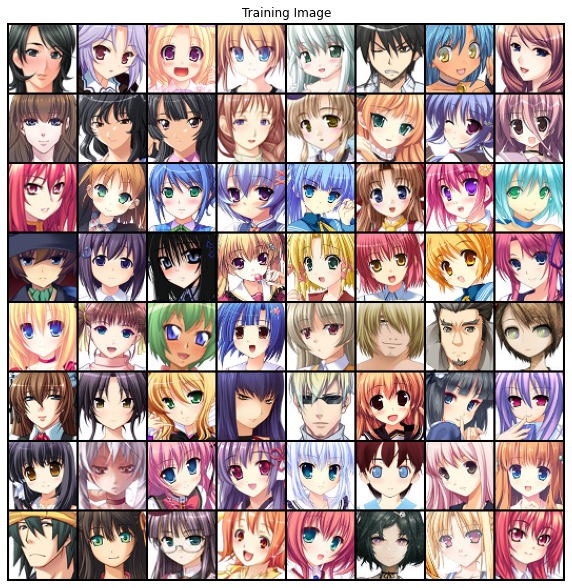

In [65]:
images, _ = next(iter(dataloader))
plt.figure(figsize=(10, 12))
plt.axis('off')
plt.title('Training Image')
grid = make_grid(images.to(device)[:64], padding=2, normalize=True).cpu()
img = np.transpose(grid, (1, 2, 0))
plt.imshow(img)

## Custom weigths

In [66]:
def weigths_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

## Generator and Discriminator

In [67]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(nn.ConvTranspose2d(NZ, NGF * 8, 4, 1, 0, bias=False),
                                   nn.BatchNorm2d(NGF * 8),
                                   nn.ReLU(True),
                                   
                                   nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(NGF * 4),
                                   nn.ReLU(True),
                                   
                                   nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(NGF * 2),
                                   nn.ReLU(True),
                                   
                                   nn.ConvTranspose2d(NGF * 2, NGF, 4, 2, 1, bias=False),
                                   nn.ReLU(True),
                                   
                                   nn.ConvTranspose2d(NGF, NC, 4, 2, 1, bias=False),
                                   nn.Tanh()
                                  )

    def forward(self, input):
        return self.model(input)

In [68]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(nn.Conv2d(NC, NDF, 4, 2, 1, bias = False),
                             nn.LeakyReLU(0.2, inplace = True),

                             nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias = False),
                             nn.BatchNorm2d(NDF * 2),
                             nn.LeakyReLU(0.2, inplace = True),

                             nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias = False),
                             nn.BatchNorm2d(NDF * 4),
                             nn.LeakyReLU(0.2, inplace = True),

                             nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias = False),
                             nn.BatchNorm2d(NDF * 8),
                             nn.LeakyReLU(0.2, inplace = True),

                             nn.Conv2d(NDF * 8, 1, 4, 1, 0 , bias = False),
                             nn.Sigmoid()
                             )
    
  def forward(self, input):
    return self.net(input)

## Create Generator

In [69]:
G_model = Generator().to(device)
G_model.apply(weigths_init)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)

## Create Discriminator

In [70]:
D_model = Discriminator().to(device)
D_model.apply(weigths_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [71]:
criterion = tr.nn.BCELoss()
optim_D = optim.Adam(D_model.parameters(), lr = LR, betas = (BETA_1, 0.999))
optim_G = optim.Adam(G_model.parameters(), lr = LR, betas = (BETA_1, 0.999))

## Training loop

In [72]:
FIXED_NOISE = tr.randn(64, NZ, 1, 1, device=device)

G_losses = []
D_losses = []

In [74]:
for epoch in range(EPOCHS):
    for i, data in enumerate(dataloader):
      # Train Discriminator
        D_model.zero_grad()

        images = data[0].to(device)
        b_size = images.size(0)
        labels = tr.full((b_size,), REAL_LABEL, dtype=tr.float, device=device)
        real_out = D_model(images).view(-1)

        loss_real = criterion(real_out, labels)
        loss_real.backward()
        dx = real_out.mean().item()

        noise = tr.randn(b_size, NZ, 1, 1, device=device)
        fake_image = G_model(noise)
        labels.fill_(FAKE_LABEL)
        fake_out = D_model(fake_image.detach()).view(-1)

        loss_fake = criterion(fake_out, labels)
        loss_fake.backward()

        dz1 = fake_out.mean().item()
        loss_D = loss_fake + loss_real
        optim_D.step()

      # Train Generator

        G_model.zero_grad()

        labels.fill_(REAL_LABEL)
        noise = torch.randn(b_size, NZ, 1, 1, device=device)
        fake_image = G_model(noise)
        output = D_model(fake_image).view(-1)

        loss_G = criterion(output, labels)
        loss_G.backward()
        dz2 = output.mean().item()
        optim_G.step()

        if i % 50 == 0:
          print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(dataloader),
                     loss_G.item(), loss_G.item(), dx, dz1, dz2))
        
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        if (ITERS % 500 == 0) or ((epoch == EPOCHS - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = G_model(FIXED_NOISE).detach().cpu()
            IMG_LIST.append(make_grid(fake, padding=2, normalize=True))            

    ITERS += 1 

[0/100][0/8]	Loss_D: 5.3874	Loss_G: 5.3874	D(x): 0.8564	D(G(z)): 0.0289 / 0.0108
[1/100][0/8]	Loss_D: 5.1863	Loss_G: 5.1863	D(x): 0.8518	D(G(z)): 0.6472 / 0.0123
[2/100][0/8]	Loss_D: 5.8803	Loss_G: 5.8803	D(x): 0.3280	D(G(z)): 0.1378 / 0.0197
[3/100][0/8]	Loss_D: 5.9021	Loss_G: 5.9021	D(x): 0.7457	D(G(z)): 0.3924 / 0.0062
[4/100][0/8]	Loss_D: 1.5721	Loss_G: 1.5721	D(x): 0.3336	D(G(z)): 0.0736 / 0.2993
[5/100][0/8]	Loss_D: 4.9873	Loss_G: 4.9873	D(x): 0.6616	D(G(z)): 0.2569 / 0.0102
[6/100][0/8]	Loss_D: 5.5431	Loss_G: 5.5431	D(x): 0.7986	D(G(z)): 0.4110 / 0.0099
[7/100][0/8]	Loss_D: 4.2788	Loss_G: 4.2788	D(x): 0.5281	D(G(z)): 0.0499 / 0.0238
[8/100][0/8]	Loss_D: 3.1859	Loss_G: 3.1859	D(x): 0.8809	D(G(z)): 0.1910 / 0.0762
[9/100][0/8]	Loss_D: 4.2172	Loss_G: 4.2172	D(x): 0.1676	D(G(z)): 0.0054 / 0.0275
[10/100][0/8]	Loss_D: 8.2748	Loss_G: 8.2748	D(x): 0.8804	D(G(z)): 0.5774 / 0.0008
[11/100][0/8]	Loss_D: 3.7357	Loss_G: 3.7357	D(x): 0.6625	D(G(z)): 0.0426 / 0.0349
[12/100][0/8]	Loss_D: 3.50

## Plot of losses

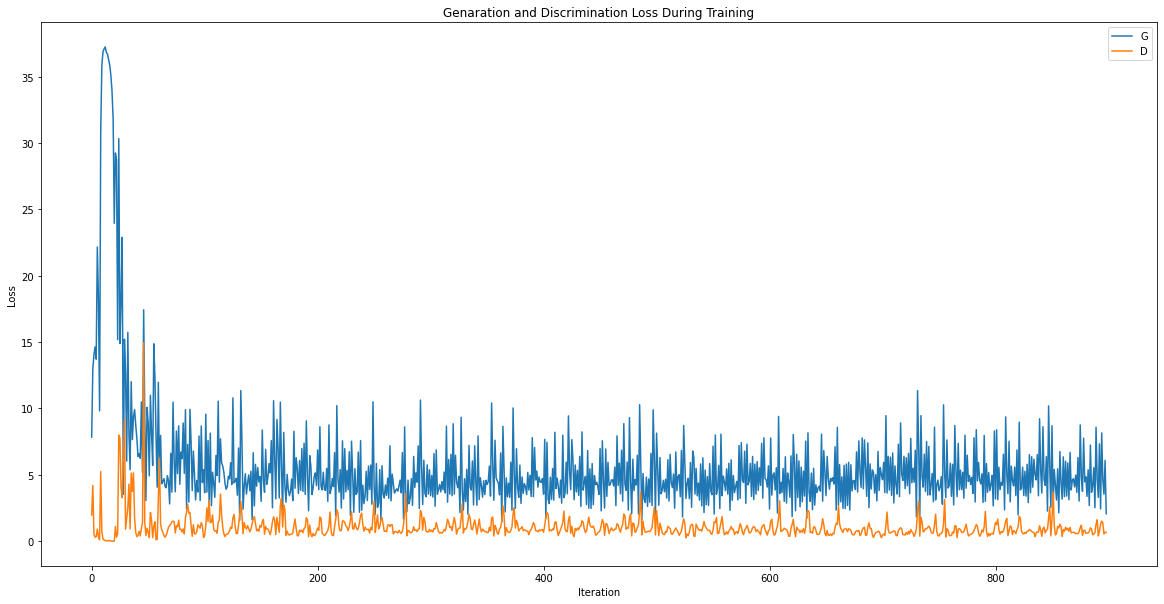

In [75]:
plt.figure(figsize=(20,10))
plt.title('Genaration and Discrimination Loss During Training')
plt.plot(G_losses, label = 'G')
plt.plot(D_losses, label = 'D')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

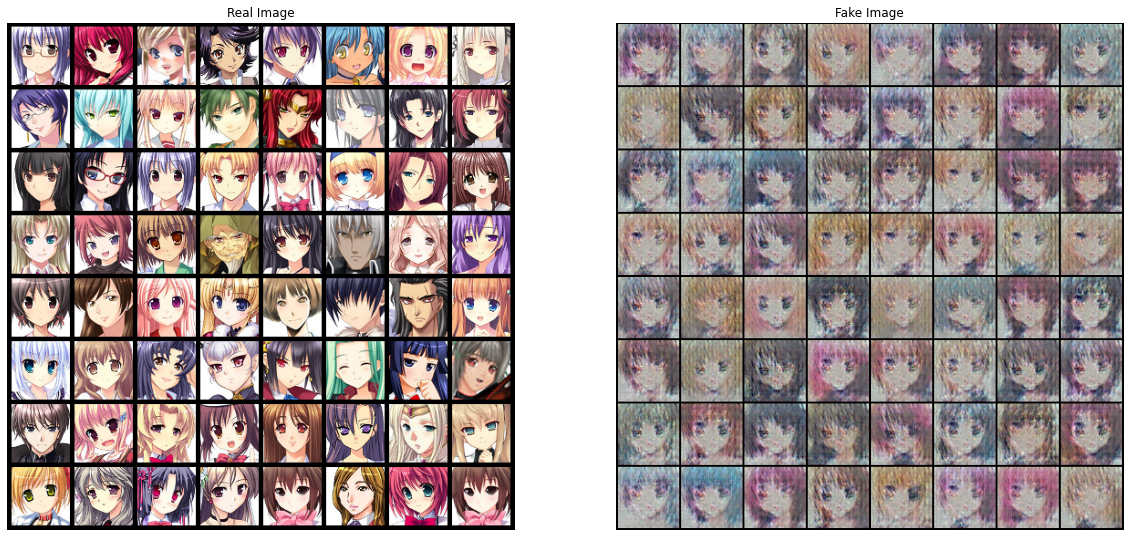

In [76]:
real_bath = next(iter(dataloader))

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Real Image')
grid = make_grid(images.to(device)[:64], padding=5, normalize=True).cpu()
real_img = np.transpose(grid, (1, 2, 0))
plt.imshow(real_img)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Fake Image')
plt.imshow(np.transpose(IMG_LIST[-1], (1, 2, 0)))
plt.show()